In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyscf import scf
from ase.io import read
from ase import Atoms

# August 23 Meeting

Broad overview -- try atomization energies using the single atom energy references but from the CCSD(T) calculation energies, not the reference atomization energies. Need to find the error in `pred_atm.dat` printing that prints the total energies as opposed to the atomization energies. Need to use a model good for total energies (and soon, atomization energies) to see the Eref vs Epred (both total and atomization), as well as xcdiff, pre-trained SCAN model, and the model taught with default settings. Also need to check Sebastian's CCSD(T) energies to see if they align with mine.

 - Check Sebastian's CCSD(T) energies and plot against mine
 - Check plot of G2/97 Atomization Energies vs. CCSD(T) Atomization Energies (both using the single-atom reference energies)
 - Plot (Eref,Epred), total and atomization, for:
     - XCDiff
     - PT SCAN
     - Model with default settings
     - Model with "good" total energy predictions

#### First check -- density matrix shapes in Sebastian's "reference data" folder

In [134]:
srp = '/home/awills/Documents/Research/xcdiff/data/ref/6-311'
srpdms = sorted([i for i in os.listdir(srp) if 'dm' in i], key = lambda x: int(x.split('.')[0]))
for dmp in srpdms:
    dm = np.load(os.path.join(srp, dmp))
    print(dm.shape)

(2, 30, 30)
(2, 78, 78)
(2, 78, 78)
(2, 93, 93)
(2, 117, 117)
(2, 94, 94)
(2, 78, 78)
(2, 78, 78)
(2, 108, 108)
(2, 78, 78)
(2, 62, 62)
(2, 54, 54)
(2, 94, 94)
(2, 39, 39)
(2, 47, 47)
(2, 39, 39)
(2, 15, 15)
(2, 39, 39)
(2, 39, 39)
(2, 47, 47)
(2, 39, 39)
(2, 78, 78)
(2, 54, 54)
(2, 54, 54)


## ALL OF SEBASTIAN'S DENSITY MATRIX REFERENCES ARE POLARIZED, IGNORING CLOSED/OPEN OR INFO FLAGS THAT INDICATE UNPOLARIZED.

#### Sebastian's CCSD(T) energies against mine

In [215]:
sebep = '/home/awills/Documents/Research/xcdiff/data/ccsdt'
seben = np.loadtxt(os.path.join(sebep, 'progress'))
alp = '/home/awills/Documents/Research/swxcd/seawulf/g297/'
sebdm = sorted([i for i in os.listdir(sebep) if 'dm' in i and '_' not in i], key = lambda x: int(x.split('.')[0]))
aldm = sorted([i for i in os.listdir(alp) if 'dm' in i] , key = lambda x: int(x.split('_')[0]))


alen = pd.read_csv('/home/awills/Documents/Research/swxcd/seawulf/g297/progress', delimiter='\t')
xcd = read('/home/awills/Documents/Research/swxcd/aegis/xcd_ccsdt/calc_results.traj', ':')
alen.columns = [i.strip() for i in alen.columns]
alen['atoms.symbols'] = alen['atoms.symbols'].str.strip()
altrj = read('/home/awills/Documents/Research/swxcd/seawulf/g297/results.traj', ':')
#results.traj file completely useless, some random collection of molecules that aren't even the whole dataset.
#sebt = read(os.path.join(sebep, 'results.traj'), ':')
chkpts = sorted([i for i in os.listdir(sebep) if 'chkpt' in i], key = lambda x: int(x.split('.')[0]))
atoms = []
maxdmes = []
meandmes = []
sumdmes = []
for idx, ic in enumerate(chkpts):
    tmp = scf.chkfile.load_scf(os.path.join(sebep, ic))
    atom = tmp[0].atom
    astr = ''.join([at[0] for at in atom])
    apos = [at[1] for at in atom]
    atobj = Atoms(astr, positions = apos)
    atobj.info['energy'] = seben[idx]
    atoms.append(Atoms(astr, positions = apos))
    
    adm = np.load(os.path.join(alp, aldm[idx]))
    sdm = np.load(os.path.join(sebep, sebdm[idx]))
    
    if len(sdm.shape) > len(adm.shape):
        #average polarizations
        sdm = (sdm[0] + sdm[1])/2
    
    #print(adm.shape, sdm.shape)
    maxdmes.append(np.max(adm-sdm))
    meandmes.append(np.mean(adm-sdm))
    sumdmes.append(np.sum(abs(adm-sdm)))
    
cols = alen.columns
symbs = [str(at.symbols) for at in atoms]
xcdsym = [str(at.symbols) for at in xcd]
ordes = np.array([alen[alen['atoms.symbols'] == sym][cols[2]].values[0] for sym in symbs])

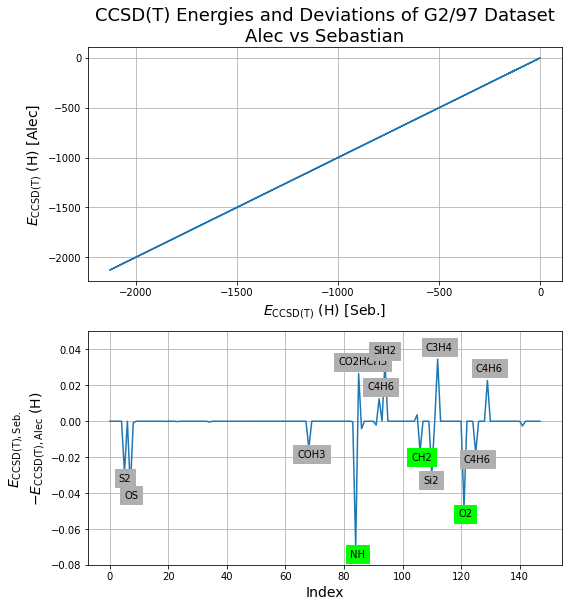

In [195]:
f = plt.figure(figsize=(8,12))
eax = f.add_subplot(311)
dax = f.add_subplot(312)
axes = [eax,dax]
dev = seben[:, 1]-ordes
eax.plot(seben[:, 1], ordes)
dax.plot(dev)

for ax in axes:
    ax.grid()
for idx, d in enumerate(dev):
    if abs(d) > 0.01:
        if symbs[idx] in xcdsym:
            dax.annotate(symbs[idx], (idx-len(symbs[idx]), d+np.sign(d)*0.005),
                        backgroundcolor="#00ff00")
        else:
            dax.annotate(symbs[idx], (idx-len(symbs[idx]), d+np.sign(d)*0.005),
                        backgroundcolor="#afafaf")

eax.set_ylabel('$E_\mathrm{CCSD(T)}$ (H) [Alec]', fontsize=14)
eax.set_xlabel('$E_\mathrm{CCSD(T)}$ (H) [Seb.]', fontsize=14)

dax.set_xlabel('Index', fontsize=14)
dax.set_ylabel('$E_\mathrm{CCSD(T),Seb.}$\n$- E_\mathrm{CCSD(T),Alec}$ (H)', fontsize=14)

dax.set_ylim(-0.08, 0.05)

eax.set_title('CCSD(T) Energies and Deviations of G2/97 Dataset\nAlec vs Sebastian', fontsize=18)

plt.tight_layout()

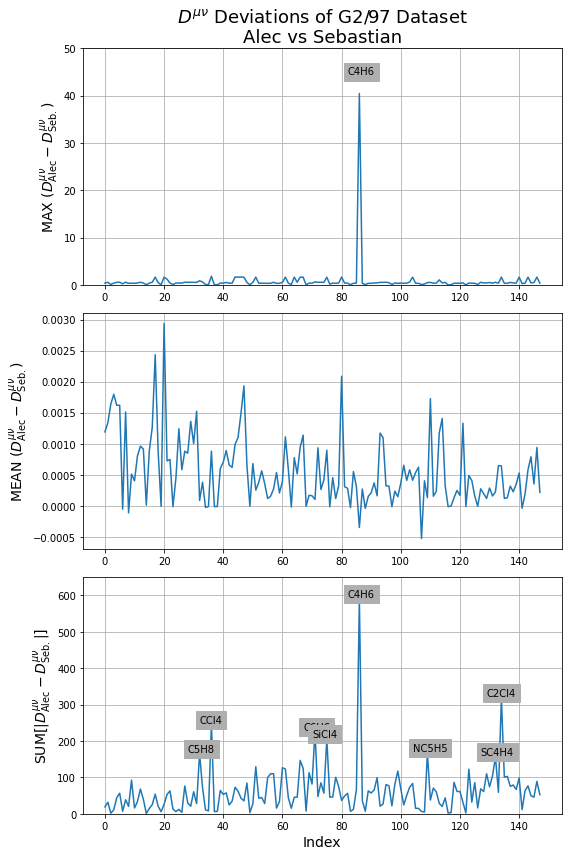

In [272]:
f = plt.figure(figsize=(8,12))
dmax = f.add_subplot(311)
dmean = f.add_subplot(312, sharex=dmax)
dsum = f.add_subplot(313, sharex=dmean)
axes = [dmax,dmean,dsum]
dmax.plot(maxdmes)
dmean.plot(meandmes)
dsum.plot(sumdmes)
for ax in axes[:3]:
    ax.grid()

dmax.set_ylim(0, 50)
for idx, d in enumerate(maxdmes):
    if d > 2:
        if symbs[idx] in xcdsym:
            dmax.annotate(symbs[idx], (idx-len(symbs[idx]), d+len(symbs[idx])*np.sign(d)*1),
                        backgroundcolor="#00ff00", alpha=0.01)
        else:
            dmax.annotate(symbs[idx], (idx-len(symbs[idx]), d+len(symbs[idx])*np.sign(d)*1),
                        backgroundcolor="#afafaf")

dsum.set_ylim(0, 650)
for idx, d in enumerate(sumdmes):
    if d > 150:
        if symbs[idx] in xcdsym:
            dsum.annotate(symbs[idx], (idx-len(symbs[idx]), d+len(symbs[idx])*np.sign(d)*1),
                        backgroundcolor="#00ff00", alpha=0.01)
        else:
            dsum.annotate(symbs[idx], (idx-len(symbs[idx]), d+len(symbs[idx])*np.sign(d)*1),
                        backgroundcolor="#afafaf")

            
            
dmax.set_ylabel('MAX $(D^{\mu\\nu}_\mathrm{Alec} - D^{\mu\\nu}_\mathrm{Seb.})$', fontsize=14)
dmean.set_ylabel('MEAN $(D^{\mu\\nu}_\mathrm{Alec} - D^{\mu\\nu}_\mathrm{Seb.})$', fontsize=14)
dsum.set_ylabel('SUM[$|D^{\mu\\nu}_\mathrm{Alec} - D^{\mu\\nu}_\mathrm{Seb.}|$]', fontsize=14)
dsum.set_xlabel('Index', fontsize=14)

dmax.set_title('$D^{\mu\\nu}$ Deviations of G2/97 Dataset\nAlec vs Sebastian', fontsize=18)


plt.tight_layout()

#### Check plot of G2/97 Atomization Energies vs. CCSD(T) Atomization Energies (both using the single-atom reference energies)

Atomic energies taken from Table XI in [this paper](https://doi.org/10.1103/PhysRevA.47.3649), from the column corresponding to the neutral atom. These are indices 13-20 in the reaction trajectory. Reference atomization energies in the trajectory are in eV.

In [250]:
from ase.units import Hartree

sat = read('/home/awills/Documents/Research/xcdiff/data/haunschild_g2/single_atoms.traj', ':')
g2traj = read('/home/awills/Documents/Research/xcdiff/data/haunschild_g2/g2_97.traj', ':')
atend = {str(at.symbols):0 for at in sat}
atend['Al'] = -242.346
atend['B'] = -24.65391
atend['Be'] = -14.66736
atend['C'] = -37.8450
atend['Cl'] = -460.148
atend['F'] = -99.7339
atend['H'] = -0.5
atend['Li'] = -7.47806
atend['N'] = -54.5892
atend['Na'] = -162.2546
atend['O'] = -75.0673
atend['P'] = -341.259
atend['S'] = -398.110
atend['Si'] = -289.359

accsdt_aes = []
sccsdt_aes = []
ref_aes = []
for idx, at in enumerate(altrj):
    syms = at.get_chemical_symbols()
    e = at.calc.results['energy']
    se = seben[idx][1]
    for s in syms:
        e -= atend[s]
        se -= atend[s]
    print(at.symbols, e)
    accsdt_aes.append(e)
    sccsdt_aes.append(se)
    
    refat = g2traj[idx].calc.results['energy']/Hartree
    ref_aes.append(-refat)
    
ref_aes = np.array(ref_aes)
ccsdt_aes = np.array(ccsdt_aes)

OC -0.2894302177705441
CS 0.08085816388268086
H2 -0.17234886811845662
FH -0.130822297559547
P2 0.3869915500405341
S2 0.4760810265937607
SH 0.16439910105356148
OS 0.21971958565660543
C2H -0.3227352923141211
CF4 -0.3388925791515476
CH4 -0.6164480442492533
CO2 -0.422158757033543
SCS 0.21348518927231908
FOF 0.12099032758523265
BeH -0.045726658834585265
OH2 -0.2931017426835183
SH2 0.013978715164569167
Cl2 0.7001087762583893
CNH -0.3875540437589322
COH -0.3196048756290111
ClH 0.2245460493787732
N2O -0.23331445619344038
NF3 0.016414043599240813
NO2 -0.14917985889360352
Li2 0.022839082283955037
LiF -0.09398205221793887
LiH -0.06001992441894988
PF3 0.0005890179373295723
PH3 -0.09819286124314885
Na2 0.47703222296445347
SO2 0.05342072484316418
SiO 0.04408323028430061
C5H8 -1.7939714355134413
C3H4 -0.9681473006729107
C2H3 -0.6078488589864719
C2H5 -0.8587004582890927
CCl4 1.1249779317910225
COH3 -0.5106993298513487
CSH3 -0.25272142994867863
CHF3 -0.4007282967688184
OCF2 -0.3574228886642743
AlF3 -0.

/home/awills/anaconda3/envs/rsrch/lib/python3.7/site-packages/ase/io/jsonio.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.array(obj)


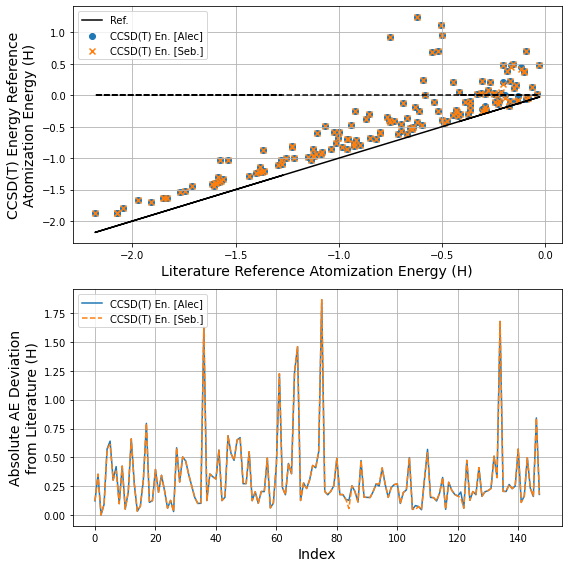

In [271]:
f = plt.figure(figsize=(8,8))
eax = f.add_subplot(211)
dax = f.add_subplot(212)
adev = abs(ref_aes - accsdt_aes)
sdev = abs(ref_aes - sccsdt_aes)

eax.plot(ref_aes, ref_aes, 'k-', label='Ref.')
eax.plot(ref_aes, np.zeros_like(ref_aes), 'k--')
eax.scatter(ref_aes, accsdt_aes, label='CCSD(T) En. [Alec]')
eax.scatter(ref_aes, sccsdt_aes, marker='x', label='CCSD(T) En. [Seb.]')

dax.plot(adev, label='CCSD(T) En. [Alec]')
dax.plot(sdev, '--', label='CCSD(T) En. [Seb.]')

dax.grid()
eax.grid()

eax.set_xlabel("Literature Reference Atomization Energy (H)",fontsize=14)
eax.set_ylabel('CCSD(T) Energy Reference\nAtomization Energy (H)', fontsize=14)

dax.set_xlabel('Index', fontsize=14)
dax.set_ylabel('Absolute AE Deviation\nfrom Literature (H)', fontsize=14)

eax.legend()
dax.legend(loc='upper left')

plt.tight_layout()
